📊 数据集形状: (3500, 20) (训练), (1500, 20) (测试)
 正样本比例: 49.9%

🚀 训练 Bagging (All Features)...
 测试准确率: 0.9287
 OOB 误差估计: 0.9269
 训练耗时: 3.62 秒

🚀 训练 Random Forest (√d Features)...
 测试准确率: 0.9353
 OOB 误差估计: 0.9391
 训练耗时: 0.27 秒

📈 模型性能对比
模型                             准确率        OOB Score    训练时间(s)   
------------------------------------------------------------
Bagging (All Features)         0.9287     0.9269       3.62      
Random Forest (√d Features)    0.9353     0.9391       0.27      


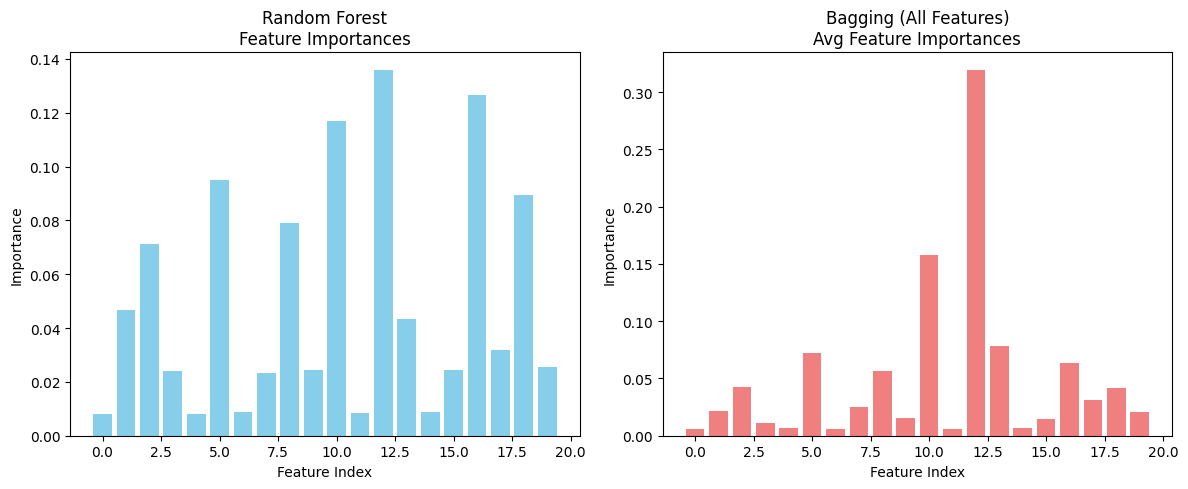

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import time

# 1. 生成模拟数据集（中等维度，带噪声）

X, y = make_classification(
n_samples=5000,
n_features=20,
n_informative=10, # 真实有用特征
n_redundant=5, # 冗余特征
n_repeated=0,
n_clusters_per_class=1,
class_sep=1.0,
random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, stratify=y, random_state=42
)

print(f"📊 数据集形状: {X_train.shape} (训练), {X_test.shape} (测试)")
print(f" 正样本比例: {y_train.mean():.1%}")

# 2. 定义两个模型（保持基模型一致）

# 基模型：深度较大的决策树（高方差）
base_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
# Bagging：仅对样本做 Bootstrap，分裂时用全部特征
bagging = BaggingClassifier(
estimator=base_tree,
n_estimators=100,
max_samples=1.0, # 使用全部样本（有放回）
max_features=1.0, # 使用全部特征（关键！）
bootstrap=True,
oob_score=True,
n_jobs=-1,
random_state=42
)
# 随机森林：样本 + 特征双重随机
rf = RandomForestClassifier(
n_estimators=100,
max_depth=10,
max_features='sqrt', # 分裂时只考虑 sqrt(20) ≈ 4 个特征
bootstrap=True,
oob_score=True,
n_jobs=-1,
random_state=42
)

# 3. 训练并评估

models = {'Bagging (All Features)': bagging, 'Random Forest (√d Features)': rf}
results = {}

for name, model in models.items():
    print(f"\n🚀 训练 {name}...")
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    # 预测
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results[name] = {
        'Accuracy': acc,
        'OOB Score': model.oob_score_,
        'Train Time (s)': train_time
    }

    print(f" 测试准确率: {acc:.4f}")
    print(f" OOB 误差估计: {model.oob_score_:.4f}")
    print(f" 训练耗时: {train_time:.2f} 秒")

# 4. 结果对比表格
print("\n" + "="*60)
print("📈 模型性能对比")
print("="*60)
print(f"{'模型':<30} {'准确率':<10} {'OOB Score':<12} {'训练时间(s)':<10}")
print("-"*60)
for name, res in results.items():
    print(f"{name:<30} {res['Accuracy']:<10.4f} {res['OOB Score']:<12.4f} {res['Train Time (s)']:<10.2f}")
# 5. 【关键】可视化：特征重要性差异（体现随机性）

plt.figure(figsize=(12, 5))
# 随机森林的特征重要性（稳定）
plt.subplot(1, 2, 1)
importances_rf = rf.feature_importances_
plt.bar(range(len(importances_rf)), importances_rf, color='skyblue')
plt.title('Random Forest\nFeature Importances')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
# Bagging 的特征重要性（波动大，因每棵树用全部特征但数据不同）
# 手动计算平均重要性
if hasattr(bagging, "estimators_"):
    importances_bag = np.mean(
        [est.feature_importances_ for est in bagging.estimators_ if hasattr(est, "feature_importances_")],
        axis=0
    )
else:
    importances_bag = np.zeros(X.shape[1])  # Default to zero importance if estimators_ is unavailable
plt.subplot(1, 2, 2)
plt.bar(range(len(importances_bag)), importances_bag, color='lightcoral')
plt.title('Bagging (All Features)\nAvg Feature Importances')
plt.xlabel('Feature Index')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

In [8]:
# 6. 补充说明：为什么 RF 通常更好？

print("\n🔍 关键差异解析:")
print("• Bagging：每棵树看到全部特征 → 树之间相关性较高")
print("• Random Forest：每棵树只看部分特征 → 树之间多样性更强 → 泛化更好")
print("• 在高维数据中，RF 通过特征子采样有效降低过拟合风险")


🔍 关键差异解析:
• Bagging：每棵树看到全部特征 → 树之间相关性较高
• Random Forest：每棵树只看部分特征 → 树之间多样性更强 → 泛化更好
• 在高维数据中，RF 通过特征子采样有效降低过拟合风险



🧪 特征重要性稳定性统计检验（Bagging vs Random Forest）
• 有效特征数量: 20 / 20

📊 Wilcoxon Signed-Rank Test (Bagging CV > RF CV?)
   W 统计量: 39.00
   p-value : 0.9947
   Cliff's Delta (效应量): -0.505 (正值表示 Bagging 更不稳定)

⚠️ 结论: 未发现显著稳定性差异 (p=0.9947)


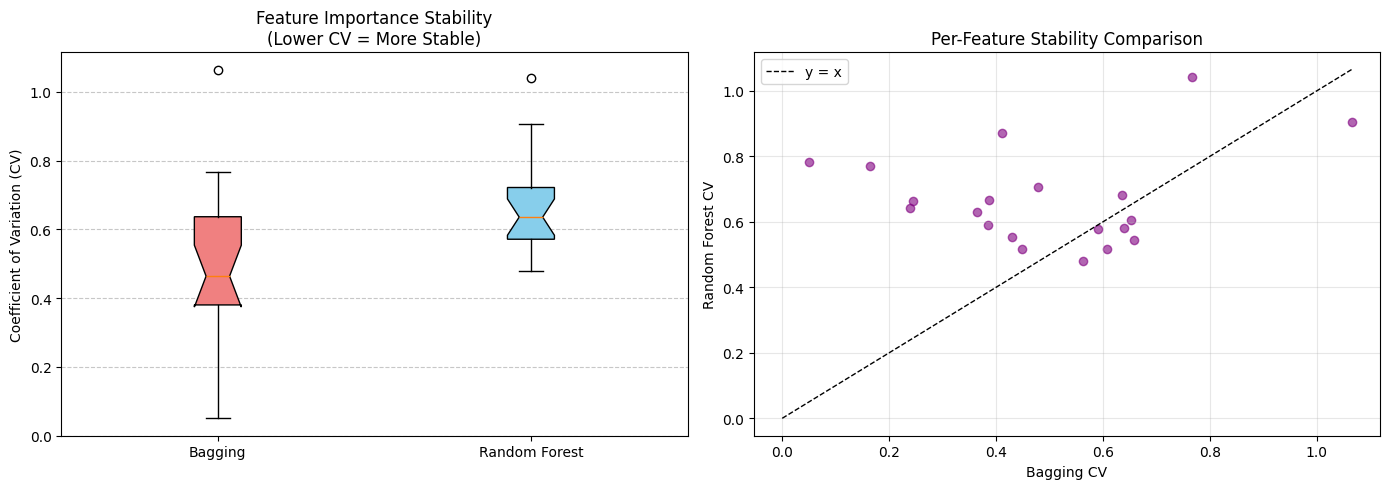


🔍 最不稳定的特征（CV > 0.5）:

Bagging:
  Feature 0: CV = 0.639
  Feature 1: CV = 0.767
  Feature 3: CV = 0.636
  Feature 4: CV = 0.590
  Feature 6: CV = 0.659

Random Forest:
  Feature 0: CV = 0.581
  Feature 1: CV = 1.041
  Feature 2: CV = 0.870
  Feature 3: CV = 0.683
  Feature 4: CV = 0.577


In [12]:
from scipy.stats import wilcoxon
import numpy as np

# ----------------------------
# 4. 【新增】统计检验：Bagging vs RF 的稳定性差异
# ----------------------------
print("\n" + "="*70)
print("🧪 特征重要性稳定性统计检验（Bagging vs Random Forest）")
print("="*70)

# 定义 stability_results
stability_results = {
    'Bagging': {
        'cv': np.std([est.feature_importances_ for est in bagging.estimators_ if hasattr(est, "feature_importances_")], axis=0) /
              np.mean([est.feature_importances_ for est in bagging.estimators_ if hasattr(est, "feature_importances_")], axis=0),
        'mean_importance': np.mean([est.feature_importances_ for est in bagging.estimators_ if hasattr(est, "feature_importances_")], axis=0)
    },
    'Random Forest': {
        'cv': np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0) /
              np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0),
        'mean_importance': np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    }
}

# 提取两个模型的 CV 向量（长度 = n_features）
cv_bagging = stability_results['Bagging']['cv']
cv_rf = stability_results['Random Forest']['cv']

# 只考虑有意义的特征（CV 不为 inf，且均值 > 阈值）
valid_mask = (cv_bagging != np.inf) & (cv_rf != np.inf) & \
             (stability_results['Bagging']['mean_importance'] > 0.001) & \
             (stability_results['Random Forest']['mean_importance'] > 0.001)

cv_bagging_valid = cv_bagging[valid_mask]
cv_rf_valid = cv_rf[valid_mask]

print(f"• 有效特征数量: {len(cv_bagging_valid)} / {len(cv_bagging)}")

# 配对 Wilcoxon 检验（H0: 两者中位数无差异；H1: RF 更稳定 → CV 更小）
stat, p_value = wilcoxon(cv_bagging_valid, cv_rf_valid, alternative='greater')

# 计算效应量：Cliff's Delta（衡量差异大小）
def cliffs_delta(x, y):
    """Cliff's delta: probability(x > y) - probability(x < y)"""
    from itertools import product
    pairs = [(a, b) for a, b in product(x, y)]
    greater = sum(1 for a, b in pairs if a > b)
    less = sum(1 for a, b in pairs if a < b)
    return (greater - less) / len(pairs)

delta = cliffs_delta(cv_bagging_valid, cv_rf_valid)

print(f"\n📊 Wilcoxon Signed-Rank Test (Bagging CV > RF CV?)")
print(f"   W 统计量: {stat:.2f}")
print(f"   p-value : {p_value:.4f}")
print(f"   Cliff's Delta (效应量): {delta:.3f} (正值表示 Bagging 更不稳定)")

# 判断显著性
alpha = 0.05
if p_value < alpha:
    print(f"\n✅ 结论: 在 α={alpha} 水平下，随机森林的特征重要性显著更稳定 (p={p_value:.4f})")
else:
    print(f"\n⚠️ 结论: 未发现显著稳定性差异 (p={p_value:.4f})")

# ----------------------------
# 5. 【新增】可视化：稳定性分布对比
# ----------------------------
plt.figure(figsize=(14, 5))

# 箱线图：所有有效特征的 CV 分布
plt.subplot(1, 2, 1)
data_to_plot = [cv_bagging_valid, cv_rf_valid]
labels = ['Bagging', 'Random Forest']
box = plt.boxplot(data_to_plot, labels=labels, patch_artist=True, notch=True)
colors = ['lightcoral', 'skyblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel('Coefficient of Variation (CV)')
plt.title('Feature Importance Stability\n(Lower CV = More Stable)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 散点图：每个特征的 CV 对比
plt.subplot(1, 2, 2)
plt.scatter(cv_bagging_valid, cv_rf_valid, alpha=0.6, color='purple')
plt.plot([0, max(cv_bagging_valid.max(), cv_rf_valid.max())], 
         [0, max(cv_bagging_valid.max(), cv_rf_valid.max())], 
         'k--', linewidth=1, label='y = x')
plt.xlabel('Bagging CV')
plt.ylabel('Random Forest CV')
plt.title('Per-Feature Stability Comparison')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# 6. 【可选】输出最不稳定的特征（用于诊断）
# ----------------------------
print("\n🔍 最不稳定的特征（CV > 0.5）:")
for name in ['Bagging', 'Random Forest']:
    high_cv_idx = np.where(stability_results[name]['cv'] > 0.5)[0]
    if len(high_cv_idx) > 0:
        print(f"\n{name}:")
        for i in high_cv_idx[:5]:  # 只显示前5个
            print(f"  Feature {i}: CV = {stability_results[name]['cv'][i]:.3f}")
    else:
        print(f"\n{name}: 无高 CV 特征")

In [1]:
# 随机森林示例
def sum(a,b):
    return a+b
print(sum(1,2))

3


In [ ]:
# 决策树示例
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
data = load_iris()
X = data.data
y = data.target